In [1]:
# pip install showast # for displaying ast

In [2]:
# pip install graphviz # showast dependency

In [3]:
# pip install astunparse

In [3]:
import ast
import showast
import numpy as np
import astunparse

---

---

### Useful Stuff

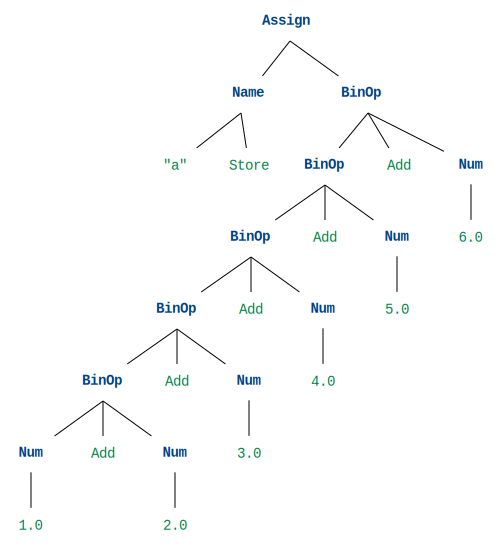

In [10]:
%%showast
a = 1. + 2. + 3. + 4.

---

### Conditions

Aim:
- Reverse chains of series with same operation e.g. a + b + c * d * e -> e * d * c + b + c
- Convert subtractions to additions of negatives e.g. a - b + c -> a + (-b) + c -> c + (-b) + a  DONE
- Convert divisions to multiplication of reciprocal e.g. a / b * c -> c * 1/b * a  DONE


notes:
- store op type each time and compare with next op: temp_op = ... || if current_op == temp_op: swap || else: 
- change nums following sub/div by

---


---

To run again cells must be executed starting from where the source is defined

### Next:

- Put everything into functions x
- Random reorder
- Target 'associative' BinOps only (addition, multiplication)
- Consider case like x - y - z and convert to x - (y + z)
- Consider BinOps to the right as well as left, e.g. with dispersed bracketing / priority operations either side of less 
- Transcendental functions

---
---

### Conditions

Case 1: a + b * c -> c * b + a

Case 2: a + b + c * d * e -> e * d * c + b + a

Case 3: a + b * c + d * e -> e * d + c * b + a

Case 4: a + b - c -> -c + b + c

Case 5: a * b / c -> 1/c * b * a

Case 6: a**(b + c + d)

Case 7: -a + b + c

In [5]:
class BinOpFilter(ast.NodeTransformer):
    def visit_BinOp(self, node):
        # Preprocessing: convert all instances of division and subtraction to multiplication and addidtion
    
        if isinstance(node.op, ast.Sub):      # replace '-_' with '+ (-_)'
            temp = node.right
            node.right = ast.UnaryOp(ast.USub(), temp)
            node.op = ast.Add()
                
        self.generic_visit(node)  # ensures all child nodes are visited
        
        # different approach for '/' ... as there will be '/' in the output, generic_visit would never stop
        for tempnode in ast.walk(node):                
            if isinstance(node.op, ast.Div):      # replace '/_' with '* (1/_)'
                temp = node.right
                node.right = ast.BinOp(ast.Num(n=1.), ast.Div(), temp)
                node.op = ast.Mult()

        return node


### Demonstrating filter on subtraction

In [6]:
source_code = 'a + 2. - (c - d)'
tree = ast.parse(source_code)

In [7]:
print(astunparse.unparse(tree))
vis_filter = BinOpFilter()
vis_filter.visit(tree)
print(astunparse.unparse(tree))


((a + 2.0) - (c - d))


((a + 2.0) + (- (c + (- d))))



In [18]:
vis_reverse = BinOpReverse()
vis_reverse.visit(tree)

print(astunparse.unparse(tree))

((a + 2.0) + (- (c + (- d))))

1

(((- (c + (- d))) + 2.0) + a)



---

### SJT algorithm

In [36]:
# save original node for stopping condition
# left swaps right to left while counting
# save leftmost node
# rightmost swap
# right swaps left to right stop at count
# leftmost swap
# left swaps right to left stop at count
# repeat until original order repeats


# randomness: introduce at point of outputting permutation -> all permutations generated, but not all output

In [37]:
def left_swap(temp_node):
    temp = temp_node.right
    temp_node.right = temp_node.left.right
    temp_node.left.right = temp
    return temp_node

In [38]:
def exterior_swap(end_node):
        temp_node = end_node
        temp = temp_node.right
        temp_node.right = temp_node.left
        temp_node.left = temp
        return end_node
    
def sweep(node_list, node, direction=1):
    # direction=1 => right to left
    # direction=-1 => left to right
    
    nnodes = len(node_list)
    end_node = node_list[-1]
    
    if direction==1:
        for i in np.arange(nnodes - 1):
            temp_node = left_swap(node_list[i])
            print(astunparse.unparse(node))
        
        end_node = exterior_swap(end_node)
        print(astunparse.unparse(node))

    elif direction==-1: # right to left
        end_node = exterior_swap(end_node)
        print(astunparse.unparse(node))
        
        for i in np.arange(nnodes - 1):
            temp_node = left_swap(node_list[nnodes-i-2]) # check
            print(astunparse.unparse(node))
            
    return # node, node_list

In [39]:
# implementation

import copy
import random

def generate_permutations(node):
    
    orig_node_dump = ast.dump(copy.copy(node)) # stop generating once this reappears
    temp_node = node
    
    node_list = []
    
    for inode in ast.walk(node):
        if isinstance(inode, ast.BinOp):
            node_list.append(inode)
            
    nnodes = len(node_list)
    
    end_node = node_list[-1]
    start_node = node_list[0]
    
    print(astunparse.unparse(node))  # remove this to avoid duplicate
    count = 0
    if nnodes>1:
        while count==0 or ast.dump(node) != orig_node_dump:
            sweep(node_list, node, 1)
    #         node_list[-1] = left_swap(node_list[0]) # rightmost swap
            start_node = left_swap(start_node)
            print(astunparse.unparse(node))
            sweep(node_list, node, -1)
            end_node = exterior_swap(end_node)
            print(astunparse.unparse(node))
            count += 1
    
    elif nnodes==1:
        print(astunparse.unparse(node))
        node = exterior_swap(node)
        print(astunparse.unparse(node))
    
    return node
        
    

        


In [44]:
# implement
source_code = '''
a + b + c + d
'''
tree = ast.parse(source_code)
node = tree.body[0].value

generate_permutations(node)

(((a + b) + c) + d)

(((a + b) + d) + c)

(((a + d) + b) + c)

(((d + a) + b) + c)

(((d + a) + c) + b)

(((a + d) + c) + b)

(((a + c) + d) + b)

(((a + c) + b) + d)

(((c + a) + b) + d)

(((c + a) + d) + b)

(((c + d) + a) + b)

(((d + c) + a) + b)

(((d + c) + b) + a)

(((c + d) + b) + a)

(((c + b) + d) + a)

(((c + b) + a) + d)

(((b + c) + a) + d)

(((b + c) + d) + a)

(((b + d) + c) + a)

(((d + b) + c) + a)

(((d + b) + a) + c)

(((b + d) + a) + c)

(((b + a) + d) + c)

(((b + a) + c) + d)

(((a + b) + c) + d)



In [8]:
# integrate into class

In [91]:

class BinOpPermute(ast.NodeTransformer):
    # visit BinOps and changes order of 'associative' reductions
    
    # generate list of valid operation types to manipulate
    op1 = '<_ast.Add'
    op2 = '<_ast.Mult'
    op3 = '<_ast.Sub'
    op4 = '<_ast.Div'
    op5 = '<_ast.Pow'

    assosiative_ops = tuple([op1, op2])
    
    # function to perform a swap with child node to the left
    def left_swap(self, temp_node):
        temp = temp_node.right
        temp_node.right = temp_node.left.right
        temp_node.left.right = temp
        temp_node = temp_node.left
        return temp_node
    
    def exterior_swap(self, end_node):
            temp_node = end_node
            temp = temp_node.right
            temp_node.right = temp_node.left
            temp_node.left = temp
            return end_node
    
    def sweep(self, node_list: list, node, direction=1, probability=1):
        # direction=1 => right to left
        # direction=-1 => left to right

        nnodes = len(node_list)
        end_node = node_list[-1]

        if direction==1:
            for i in np.arange(nnodes - 1):
                temp_node = self.left_swap(node_list[i])
                if random.random() < probability:
                    print(astunparse.unparse(node))

            end_node = self.exterior_swap(end_node)
            if random.random() < probability:
                print(astunparse.unparse(node))
                
        elif direction==-1: # right to left
            end_node = self.exterior_swap(end_node)
            if random.random() < probability:
                print(astunparse.unparse(node))

            for i in np.arange(nnodes - 1):
                temp_node = self.left_swap(node_list[nnodes-i-2]) # check
                if random.random() < probability:
                    print(astunparse.unparse(node))

        return # node, node_list
    
##-------------------------------------------------------------------------------------------------------
    
    def generate_permutations(self, node, node_list, probability=1):
        orig_node_dump = ast.dump(copy.copy(node)) # stop generating once this reappears
        temp_node = node

        nnodes = len(node_list)

        end_node = node_list[-1]
        start_node = node_list[0]

        print(astunparse.unparse(node))  # remove this to avoid duplicate
        count = 0
        if nnodes>1:
            while count==0 or ast.dump(node) != orig_node_dump:
                self.sweep(node_list, node, 1, probability)  # right to left
                start_node = self.left_swap(start_node) # rightmost
                if random.random() < probability:
                    print(astunparse.unparse(node))
                self.sweep(node_list, node, -1, probability) # left to right
                end_node = self.exterior_swap(end_node) # leftmost
                if random.random() < probability:
                    print(astunparse.unparse(node))
                count += 1

        elif nnodes==1: # case where there are only two swappable elements
            print(astunparse.unparse(node))
            node = self.exterior_swap(node)
            print(astunparse.unparse(node))

        return node
    
    
    
    def visit_BinOp(self, node, probability=1):    
        op_type = str(node.op)                        
        
        if op_type.startswith(self.assosiative_ops):   # proceed if op at node is associative
            temp_node = node

            node_list = [temp_node] # initialise with original node

            count = 0
            
            while isinstance(temp_node.left, ast.BinOp):
                if type(temp_node.left.op) == type(temp_node.op):  # check if child node is another BinOp of the same type
                    temp_node = temp_node.left
                    node_list.append(temp_node)
                    count+=1
                else:
                    break
        
            self.generate_permutations(node, node_list, probability)
            
        else:
            return node
        
        return node

 Need walk through left side of tree, checking for consecutive binops, storing the nodes in a list and counting

In [76]:
class BinOpPrint(ast.NodeTransformer):
    # visit BinOps and changes order of 'associative' reductions
    
    def visit_BinOp(self, node, probability=1):
        print(astunparse.unparse(node))

        
        return node

In [92]:
source_code = '''
import numpy as np

from functional.common import DimensionKind
from functional.ffront.fbuiltins import Dimension, Field, float64, FieldOffset, neighbor_sum, where
from functional.ffront.decorator import field_operator, program
from functional.iterator.embedded import np_as_located_field, NeighborTableOffsetProvider

CellDim = Dimension("Cell")
KDim = Dimension("K")

num_cells = 5
num_layers = 6
grid_shape = (num_cells, num_layers)

a_value = 0.5
b_value = 2**53
c_value = 2**53
a = np_as_located_field(CellDim, KDim)(np.full(shape=grid_shape, fill_value=a_value, dtype=np.float64))
b = np_as_located_field(CellDim, KDim)(np.full(shape=grid_shape, fill_value=b_value, dtype=np.float64))
c = np_as_located_field(CellDim, KDim)(np.full(shape=grid_shape, fill_value=c_value, dtype=np.float64))

@field_operator
def trip_add(a: Field[[CellDim, KDim], float64],
            b: Field[[CellDim, KDim], float64],
            c: Field[[CellDim, KDim], float64]) -> Field[[CellDim, KDim], float64]:
        return a + b - c                                                     # relocate parentheses

result = np_as_located_field(CellDim, KDim)(np.zeros(shape=grid_shape))
trip_add(a, b, c, out=result, offset_provider={})

print("{} + {} + {} = {} +/- {}".format(a_value, b_value, c_value, np.average(np.asarray(result)), np.std(np.asarray(result))))

print(np.asarray(result))
'''

tree = ast.parse(source_code)

In [93]:
print(astunparse.unparse(tree.body[1]))


from functional.common import DimensionKind



In [97]:
vis_filter = BinOpFilter()
vis_filter.visit(tree)
vis_print = BinOpPrint()
vis_print.visit(tree)

vis_permute = BinOpPermute()
vis_permute.visit(tree)

(2 ** 53)

(2 ** 53)

((a + b) + (- c))

((a + b) + (- c))

((a + (- c)) + b)

(((- c) + a) + b)

(((- c) + b) + a)

((b + (- c)) + a)

((b + a) + (- c))

((a + b) + (- c))



In [96]:
print(astunparse.unparse(tree))


import numpy as np
from functional.common import DimensionKind
from functional.ffront.fbuiltins import Dimension, Field, float64, FieldOffset, neighbor_sum, where
from functional.ffront.decorator import field_operator, program
from functional.iterator.embedded import np_as_located_field, NeighborTableOffsetProvider
CellDim = Dimension('Cell')
KDim = Dimension('K')
num_cells = 5
num_layers = 6
grid_shape = (num_cells, num_layers)
a_value = 0.5
b_value = (2 ** 53)
c_value = (2 ** 53)
a = np_as_located_field(CellDim, KDim)(np.full(shape=grid_shape, fill_value=a_value, dtype=np.float64))
b = np_as_located_field(CellDim, KDim)(np.full(shape=grid_shape, fill_value=b_value, dtype=np.float64))
c = np_as_located_field(CellDim, KDim)(np.full(shape=grid_shape, fill_value=c_value, dtype=np.float64))

@field_operator
def trip_add(a: Field[([CellDim, KDim], float64)], b: Field[([CellDim, KDim], float64)], c: Field[([CellDim, KDim], float64)]) -> Field[([CellDim, KDim], float64)]:
    return ((a + b

---
---

### Trash

In [387]:
   
class BinOpReverse(ast.NodeTransformer):
    # visit BinOps and changes order of 'associative' reductions
    
    # generate list of valid operation types to manipulate
    op1 = '<_ast.Add'
    op2 = '<_ast.Mult'
    op3 = '<_ast.Sub'
    op4 = '<_ast.Div'
    op5 = '<_ast.Pow'

    assosiative_ops = tuple([op1, op2])
    
    # function to perform a swap with child node to the left
    def left_swap(self, temp_node):
        temp = temp_node.right
        temp_node.right = temp_node.left.right
        temp_node.left.right = temp
        temp_node = temp_node.left
        return temp_node
    # and right
    def right_swap(self, temp_node):
        temp = temp_node.left
        temp_node.left = temp_node.right.left
        temp_node.right.left = temp
        temp_node = temp_node.right
        return temp_node
    
    def visit_BinOp(self, node):
        
        op_type = str(node.op)                        
        
        if op_type.startswith(self.assosiative_ops):   # proceed if op at node is associative
            temp_node = node
            print(astunparse.unparse(node))

            count = 0
#             while str(type(temp_node.left)) == "<class '_ast.BinOp'>":  # check if child node is another BinOp
            while isinstance(temp_node.left, ast.BinOp):
                if type(temp_node.left.op) == type(temp_node.op):  # check if child node is another BinOp of the same type            
                    temp_node = self.left_swap(temp_node)   # swap neighbours
                    count+=1
                else:
                    break

            # final swap
            temp = temp_node.right
            temp_node.right = temp_node.left
            temp_node.left = temp
            
            print(count)


            i_arr = np.arange(count)

            for i in i_arr: # perform shift for each level of tree
                j = count - i # start from highest index, deepest node
                temp_node = node # reset temp_node
                
                for k in np.arange(j):
                    temp_node = self.left_swap(temp_node) # swap 

                temp = temp_node.right    # final swap
                temp_node.right = temp_node.left
                temp_node.left = temp
        


                
        else:
            return node
        
        return node
    

In [385]:
vis = BinOpReverse()
vis.visit(tree)
print(astunparse.unparse(tree))

entered
(((a + 2.0) + (- c)) + (- d))

2

((2.0 + ((- c) + (- d))) + a)



- Filter only works on first node in tree -> Try self.generic_visit(node) DONE
- Why is the reduction not being reversed? Only last element is shifted to first place

In [150]:
# problem: first reordering changes shape, mixes left & right
# -> change left_shift to look for left and right?

In [372]:
print(astunparse.unparse(tree_lorenz))
vis_filter.visit(tree_lorenz)
vis.visit(tree_lorenz)
print(astunparse.unparse(tree_lorenz))



def my_lorenz(x, y, z):
    sigma = 10.0
    b = (8.0 / 3)
    r = 28
    dt = 0.005
    dx = (sigma * (y - x))
    dy = (((r * x) - y) - (x * z))
    dz = ((x * y) - (b * z))
    x = (x + (dt * dx))
    y = (y + (dt * dy))
    z = (z + (dt * dz))
    return [x, y, z]

div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div
div


RecursionError: maximum recursion depth exceeded while calling a Python object

---
---
---

**Figuring out the *for* loop**

In [244]:
def left_swap(temp_node):
    temp = temp_node.right
    temp_node.right = temp_node.left.right
    temp_node.left.right = temp
    temp_node = temp_node.left
    return temp_node

temp_node = tree.body[0].value

count = 0
while isinstance(temp_node.left, ast.BinOp):
    if type(temp_node.left.op) == type(temp_node.op):  # check if child node is another BinOp of the same type            
        temp_node = left_swap(temp_node)   # swap neighbours
        count+=1
    else:
        break

# final swap
temp = temp_node.right
temp_node.right = temp_node.left
temp_node.left = temp


In [245]:
count

2

In [252]:
i_arr = np.arange(count)
print(i_arr)

i = i_arr[0]
j = count-i

j_arr = np.arange(j)
print(j_arr)

for k in j_arr:  # twice
    temp_node = left_swap(temp_node)


[0 1]
[0 1]


AttributeError: 'Num' object has no attribute 'right'

In [ ]:
print(astunparse.unparse(tree))

In [ ]:
i_arr = np.arange(count)

for i in i_arr: # perform shift for each level of tree
    j = count - i # start from highest index, deepest node
    temp_node = node # reset temp_node

    for k in np.arange(j):
        temp_node = left_swap(temp_node) # swap 

    temp = temp_node.right    # final swap
    temp_node.right = temp_node.left
    temp_node.left = temp

### Changing Operations

In [ ]:
# ast.copy_location(new_node, node)
# ast.fix_missing_locations(new_node)

# tree.body[0].value.op = ast.Mult()

# val = 1. / float(astunparse.unparse(node.right))
# node.right = ast.Num(n = val)
# node.op = ast.Mult()

In [193]:
print(ast.dump(tree.body[0].value.op))

Div()


In [379]:
source_code = '1. - 2.'
tree = ast.parse(source_code)

In [365]:
node = tree.body[0].value

print(astunparse.unparse(node))

if isinstance(node.op, ast.Div):
    val = 1. / float(astunparse.unparse(node.right))
    node.right = ast.Num(n = val)
    node.op = ast.Mult()
    
print(astunparse.unparse(node))

(1.0 - 2.0)

(1.0 - 2.0)



**Subtraction**

In [380]:
node = tree.body[0].value

print(astunparse.unparse(node))

if isinstance(node.op, ast.Sub):
    val = float(astunparse.unparse(node.right))
    node.right = ast.Num(n = -val)
    node.op = ast.Add()
    
print(astunparse.unparse(node))

(1.0 - 2.0)

(1.0 + -2.0)



In [382]:
print(astunparse.unparse(tree))


(1.0 + -2.0)



### Permutations

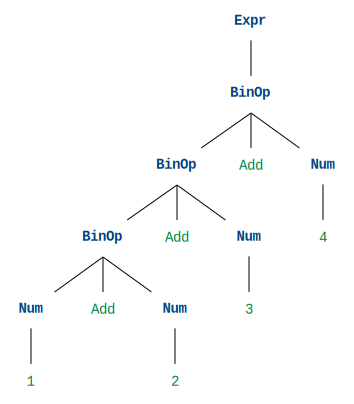

In [397]:
%%showast
1 + 2 + 3 + 4

In [239]:
# Python program to print all permutations using
# Heap's algorithm

# Generating permutation using Heap Algorithm
def heapPermutation(a, size):
    
 
    # if size becomes 1 then prints the obtained
    # permutation
    if size == 1:
        print(a)
        return
 
    for i in range(size):
        heapPermutation(a, size-1)
 
        # if size is odd, swap 0th i.e (first)
        # and (size-1)th i.e (last) element
        # else If size is even, swap ith
        # and (size-1)th i.e (last) element
        if size & 1:
            a[0], a[size-1] = a[size-1], a[0]
        else:
            a[i], a[size-1] = a[size-1], a[i]
        
 
 
# Driver code
a = [1, 2, 3, 4]
n = len(a)
heapPermutation(a, n)

[1, 2, 3, 4]
[2, 1, 3, 4]
[3, 1, 2, 4]
[1, 3, 2, 4]
[2, 3, 1, 4]
[3, 2, 1, 4]
[4, 2, 3, 1]
[2, 4, 3, 1]
[3, 4, 2, 1]
[4, 3, 2, 1]
[2, 3, 4, 1]
[3, 2, 4, 1]
[4, 1, 3, 2]
[1, 4, 3, 2]
[3, 4, 1, 2]
[4, 3, 1, 2]
[1, 3, 4, 2]
[3, 1, 4, 2]
[4, 1, 2, 3]
[1, 4, 2, 3]
[2, 4, 1, 3]
[4, 2, 1, 3]
[1, 2, 4, 3]
[2, 1, 4, 3]


### Checking type of child node

In [ ]:
# if isinstance(node.left, ast.BinOp):
# & node.left.op == node.op

### Presentation

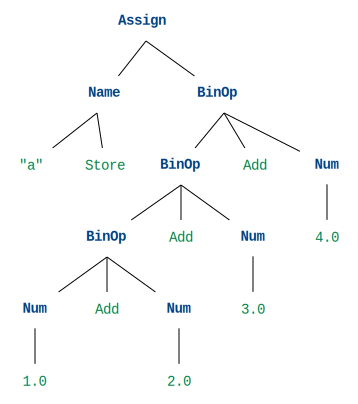

In [43]:
%%showast
a = 1. + 2. + 3. + 4.

In [44]:
source_code = '''
a = 1. + 2. + 3. + 4.
'''

tree = ast.parse(source_code)

In [45]:
reverse(tree, [2])

In [46]:
print(astunparse.unparse(tree))


a = (((3.0 + 4.0) + 2.0) + 1.0)



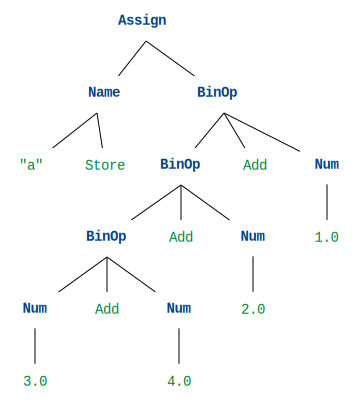

In [47]:
%%showast 
a = (((3.0 + 4.0) + 2.0) + 1.0)

---

### Messy Exploratory Stuff

In [236]:
source_code = '1.+2.+3.'
tree = ast.parse(source_code)

In [237]:
# print tree
ast.dump(tree)

'Module(body=[Expr(value=BinOp(left=BinOp(left=Constant(value=1.0), op=Add(), right=Constant(value=2.0)), op=Add(), right=Constant(value=3.0)))], type_ignores=[])'

In [238]:
print(astunparse.unparse(tree.body[0].value.left.left))

1.0



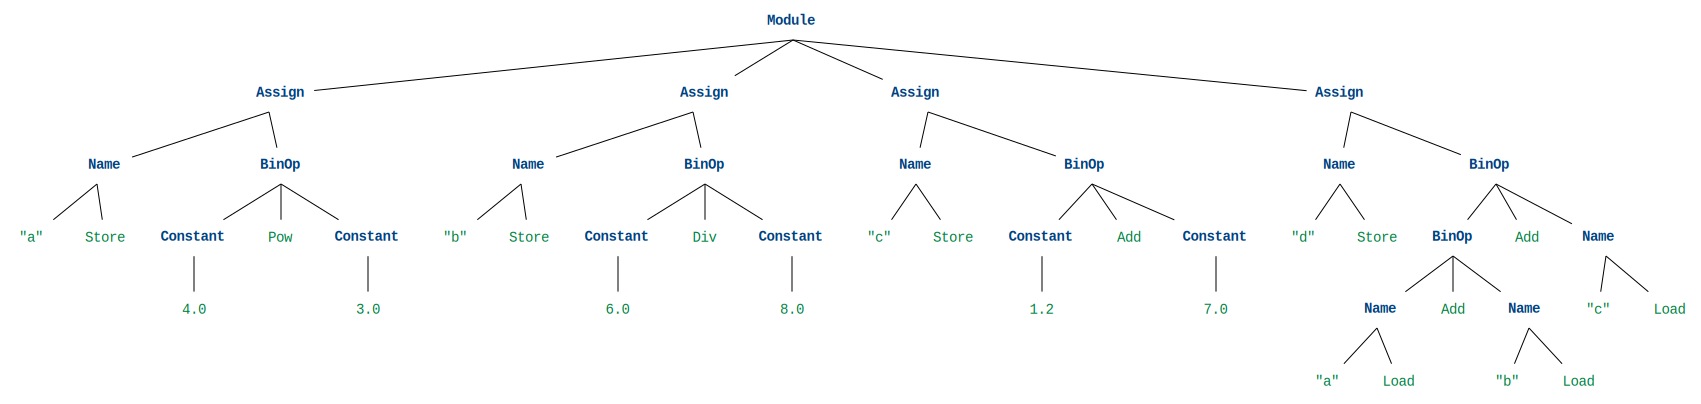

In [61]:
%%showast

a = 4.**3.
b = 6./8.
c = 1.2 + 7.

d = a + b + c

In [386]:
source_oak = """
a = 4.**3.
b = 6./8.
c = 1.2 + 7.
d = a + b + c
"""

In [387]:
tree_oak = ast.parse(source_oak)

In [388]:
for node in ast.walk(tree_oak):
    print(node.__class__.__name__)

Module
Assign
Assign
Assign
Assign
Name
BinOp
Name
BinOp
Name
BinOp
Name
BinOp
Store
Num
Pow
Num
Store
Num
Div
Num
Store
Num
Add
Num
Store
BinOp
Add
Name
Name
Add
Name
Load
Load
Load


In [389]:
for name, value in ast.iter_fields(tree_oak):
    print(name, value)

body [<_ast.Assign object at 0x0000019EBFD1BBC8>, <_ast.Assign object at 0x0000019EBFD28748>, <_ast.Assign object at 0x0000019EBFD288C8>, <_ast.Assign object at 0x0000019EBFD60C48>]


In [14]:
for node in ast.iter_child_nodes(tree_oak):
    print(node.__class__.__name__)

Assign
Assign
Assign
Assign


In [73]:
class BinOpVisitor(ast.NodeVisitor):
    def visit_BinOp(self, node):
        print(f"found BinOp at line: {node.lineno}, {node.col_offset}, {node.end_lineno}, {node.end_col_offset}")
        self.generic_visit(node)

In [400]:
print(ast.dump(tree_oak))
print(str(tree_oak.body[2].value.op))

string = str(tree_oak.body[2].value.op)
if string.startswith("<_ast.Add object"):
    print('yes')

Module(body=[Assign(targets=[Name(id='a', ctx=Store())], value=BinOp(left=Num(n=4.0), op=Pow(), right=Num(n=3.0))), Assign(targets=[Name(id='b', ctx=Store())], value=BinOp(left=Num(n=6.0), op=Div(), right=Num(n=8.0))), Assign(targets=[Name(id='c', ctx=Store())], value=BinOp(left=Num(n=1.2), op=Add(), right=Num(n=7.0))), Assign(targets=[Name(id='d', ctx=Store())], value=BinOp(left=BinOp(left=Name(id='a', ctx=Load()), op=Add(), right=Name(id='b', ctx=Load())), op=Add(), right=Name(id='c', ctx=Load())))])
yes


In [18]:
vis = BinOpVisitor()
vis.visit(tree_oak)

found BinOp at line: 2
found BinOp at line: 3
found BinOp at line: 4
found BinOp at line: 5
found BinOp at line: 5


In [19]:
import random

class ConstantTransformer(ast.NodeTransformer):
    def visit_Constant(self, node):
        new_value = random.randint(-10,10)
        new_node = ast.Constant(new_value)
        print(f"replacing constant {node.value} -> {new_value} at {node.lineno}")
        return new_node

In [20]:
vis = ConstantTransformer()
new_tree = vis.visit(tree_oak)

replacing constant 4.0 -> -5 at 2
replacing constant 3.0 -> 3 at 2
replacing constant 6.0 -> -3 at 3
replacing constant 8.0 -> -6 at 3
replacing constant 1.2 -> 5 at 4
replacing constant 7.0 -> -4 at 4


In [64]:
import ast
import astunparse

class BinOpTransformer(ast.NodeTransformer):
    def visit_BinOp(self, node):
        print(ast.dump(node))
        print(str(type(node.op)))
        if str(type(node.op)) == "<class 'ast.Add'>":
            print('true')
            # save node location

        temp = node.right
        node.right = node.left
        node.left = temp
#         print(f"replacing constant {node.value} -> at {node.lineno}")
        return node

In [66]:
class BinOpProbing(ast.NodeTransformer):
    def visit_BinOp(self, node):
        print(ast.dump(node))
        print(str(type(node.op)))
        if str(type(node.op)) == "<class 'ast.Add'>":
            print('true')
            # save node location
            
        return node

In [12]:
lim = 2  # this value should be obtained automatically from BinOpCount

for i in range(lim):  # this will be incorporated into a method
    temp = node.right
    node.right = node.left.right
    node.left.right = temp
    node = node.left
    if i==lim-1:
        temp = node.left
        node.left = home_node.right
        home_node.right = temp

In [13]:
print(astunparse.unparse(tree_ash.body[0].value)) # reversed

(((3.0 + 4.0) + 2.0) + 1.0)



In [9]:
# as function
def reverse(in_tree, count):
    
    nlines = len(in_tree.body)
    for i in range(nlines):
        home_node = in_tree.body[i].value  # initialise
        node = home_node
#         print(astunparse.unparse(home_node))
        
        lim = count[i]  # this value should be obtained automatically from BinOpCount

        for i in range(lim):  # this will be incorporated into a method
            temp = node.right
            node.right = node.left.right
            node.left.right = temp
            node = node.left
            if i==lim-1:
                temp = node.left
                node.left = home_node.right
                home_node.right = temp
                
        

In [10]:
reverse(tree_ash, [2,2])

print(astunparse.unparse(tree_ash))


a = (((5.0 + 6.0) + 4.0) + ((1.0 + 2.0) + 3.0))



---

### 14/11/22

In [308]:
source_code = 'a = 1. + 2. + 3. + 4. + 5. + 6.' # to be manipulated
# source_ash = '''
# a = 1. + 2. + 3. + 4.
# b = a + 5. + 6. + 7.
# # '''

tree = ast.parse(source_code)

# print(ast.dump(tree))

# this visits BinOps instances within the tree

def left_shift(temp_node):
        temp = temp_node.right
        temp_node.right = temp_node.left.right
        temp_node.left.right = temp
        temp_node = temp_node.left
        return temp_node
    
class BinOpReverse(ast.NodeTransformer):
    
    # visit BinOps and reverses order of 'associative' reductions
    def visit_BinOp(self, node):
        temp_node = node
        print(astunparse.unparse(node))

        count = 0
        while str(type(temp_node.left)) == "<class '_ast.BinOp'>":  # check if child node is another BinOp
#             temp = temp_node.right
#             temp_node.right = temp_node.left.right
#             temp_node.left.right = temp
#             temp_node = temp_node.left
            temp_node = left_shift(temp_node)
            count+=1
        
        # final swap
        temp = temp_node.right
        temp_node.right = temp_node.left
        temp_node.left = temp
        
        
        i_arr = np.arange(count)
        
        for i in i_arr: # perform shift for each level of tree
            j = count - i # start from highest index, deepest node
            temp_node = node
            for k in np.arange(j):
                temp_node = left_shift(temp_node)
#                 temp = temp_node.right
#                 temp_node.right = temp_node.left.right
#                 temp_node.left.right = temp
#                 temp_node = temp_node.left

            
            temp = temp_node.right
            temp_node.right = temp_node.left
            temp_node.left = temp
                
                
                
        
#         temp_node.left = node.right
#         node.right = temp # home node
        
        return node
    


### 16/11

In [93]:
string = 'ba'
na = 'na'

how_many = 6

for i in range(how_many):
    string += na
print(string)

banananananana


### 23/11

In [120]:
# converting tree div/sub by variable names to *(1/_) and - (+_)

source_test = '1 / a'   # aim: 1 * 1/a
tree_test = ast.parse(source_test)

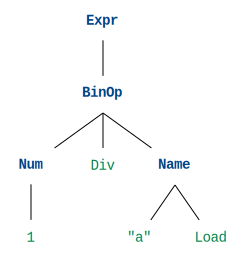

In [109]:
%%showast
1 / a

AIM:

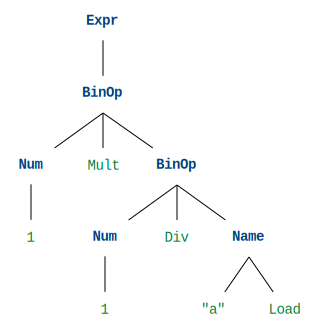

In [111]:
%%showast
1 * (1/a)

Need to convert right branch to 1/a, and div op to mult

In [131]:
# converting tree div/sub by variable names to *(1/_) and - (+_)

source_test = '1 / b'   # aim: 1 * 1/a
tree_test = ast.parse(source_test)

In [132]:
# method 1: generate tree for 1/a and sub in for node.right

print(astunparse.unparse(tree_test))

node = tree_test.body[0].value

# need to grab tree_append source from main tree

temp = node.right

# use generic version first, then reinsert original Name (in temp) on right of new node

tree_append = ast.parse('1/a') # generic version
node_append = tree_append.body[0].value

node.right = node_append

print(astunparse.unparse(tree_test))

# and change op to Mult:
tree_test.body[0].value.op = ast.Mult()

print(astunparse.unparse(tree_test))

node.right.right = temp

print(astunparse.unparse(tree_test))


(1 / b)


(1 / (1 / a))


(1 * (1 / a))


(1 * (1 / b))



This is not the most elegant solution, but should work robustly.

Later, try to construct the node myself, adding BinOp(Div,1,\_) or UnSub(\_) node to right branch


In [ ]:
# write in function form

# for div
if isinstance(node.right, ast.Name):
    temp = node.right
    tree_append = ast.parse('1/a')
    node_append = tree_append.body[0].value
    node.right = node_append
    node.right.right = temp
    
    
# for sub
if isinstance(node.right, ast.Name):
    temp = node.right
    tree_append = ast.parse('-a')
    node_append = tree_append.body[0].value
    node.right = node_append
    node.right.right = temp



---
---
### 24/11

Old Version

In [298]:
class BinOpFilter(ast.NodeTransformer):
    def visit_BinOp(self, node):
        # Preprocessing: convert all instances of division and subtraction to multiplication and addidtion
    
        if isinstance(node.op, ast.Div):      # replace '/_' with '* (1/_)'
            temp = node.right
            node.right = ast.BinOp(ast.Div(), ast.Num(n=1.), temp)
            node.op = ast.Add()
            
            if isinstance(node.right, ast.Num):
                val = 1. / float(astunparse.unparse(node.right))
                node.right = ast.Num(n = val)
                node.op = ast.Mult()
            
            elif isinstance(node.right, ast.Name):
                temp = node.right
                tree_append = ast.parse('1/a')
                node_append = tree_append.body[0].value
                node.right = node_append
                node.right.right = temp
                node.op = ast.Mult()

        if isinstance(node.op, ast.Sub):      # replace '-_' with '+ (-_)'
#             if isinstance(node.right, ast.Num):
#                 val = float(astunparse.unparse(node.right))
#                 node.right = ast.Num(n = -val)
#                 node.op = ast.Add()

#             elif isinstance(node.right, ast.Name):
            temp = node.right
            node.right = ast.UnaryOp(ast.USub(), temp)
            node.op = ast.Add()
                
        self.generic_visit(node)  # ensures all child nodes are visited
            
        return node


In [8]:
# this visits BinOps instances within the tree
    
class BinOpReverse(ast.NodeTransformer):
    # visit BinOps and reverses order of 'associative' reductions
    
    # generate list of valid operation types to manipulate
    op_add = '<_ast.Add'
    op_mult = '<_ast.Mult'
    op_sub = '<_ast.Sub'
    op_div = '<_ast.Div'
    op_pow = '<_ast.Pow'

    assosiative_ops = tuple([op_add, op_mult])
    
    # function to perform a swap with child node to the left
    def left_swap(self, temp_node):
        temp = temp_node.right
        temp_node.right = temp_node.left.right
        temp_node.left.right = temp
        temp_node = temp_node.left
        return temp_node
    
    def visit_BinOp(self, node):
        
        op_type = str(node.op)
        
        if op_type.startswith(self.assosiative_ops):   # proceed if op at node is associative
            temp_node = node
            print(astunparse.unparse(node))
            print(str(type(node)))

            count = 0
            while str(type(temp_node.left)) == "<class '_ast.BinOp'>":  # check if child node is another BinOp            
                temp_node = self.left_swap(temp_node)
                count+=1

            # final swap
            temp = temp_node.right
            temp_node.right = temp_node.left
            temp_node.left = temp


            i_arr = np.arange(count)

            for i in i_arr: # perform shift for each level of tree
                j = count - i # start from highest index, deepest node
                temp_node = node
                for k in np.arange(j):
                    temp_node = self.left_swap(temp_node)

                temp = temp_node.right    # final swap
                temp_node.right = temp_node.left
                temp_node.left = temp
        else:
            return node
        
        return node
    

----

---

In [381]:
source_lorenz = """
def my_lorenz(x, y, z):
    sigma = 10.
    b = 8./3
    r = 28
    dt = 0.005
    dx = sigma*(y-x)
    dy = (r*x) - y - (x*z)
    dz = (x*y) - (b*z)
    x = x + dt*dx
    y = y + dt*dy
    z = z + dt*dz
    return[x, y, z]  # changed to output array
"""
tree_lorenz = tree = ast.parse(source_lorenz)

In [382]:
print(astunparse.unparse(tree_lorenz))
vis.visit(tree_lorenz)
print(astunparse.unparse(tree_lorenz))



def my_lorenz(x, y, z):
    sigma = 10.0
    b = (8.0 / 3)
    r = 28
    dt = 0.005
    dx = (sigma * (y - x))
    dy = (((r * x) - y) - (x * z))
    dz = ((x * y) - (b * z))
    x = (x + (dt * dx))
    y = (y + (dt * dy))
    z = (z + (dt * dz))
    return [x, y, z]

entered
(sigma * (y - x))

0
entered
(x + (dt * dx))

0
entered
(y + (dt * dy))

0
entered
(z + (dt * dz))

0


def my_lorenz(x, y, z):
    sigma = 10.0
    b = (8.0 / 3)
    r = 28
    dt = 0.005
    dx = ((y - x) * sigma)
    dy = (((r * x) - y) - (x * z))
    dz = ((x * y) - (b * z))
    x = ((dt * dx) + x)
    y = ((dt * dy) + y)
    z = ((dt * dz) + z)
    return [x, y, z]



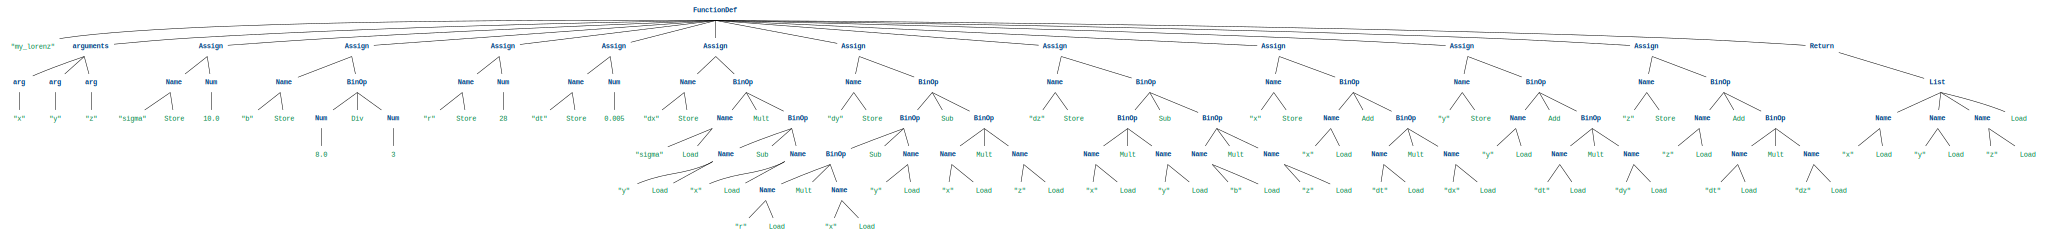

In [383]:
%%showast
def my_lorenz(x, y, z):
    sigma = 10.
    b = 8./3
    r = 28
    dt = 0.005
    dx = sigma*(y-x)
    dy = (r*x) - y - x*z
    dz = (x*y) - (b*z)
    x = x + dt*dx
    y = y + dt*dy
    z = z + dt*dz
    return[x, y, z]  # changed to output array

---
### 02/12/22

---

### Aim: Figure out what makes AST change shape in reversal algorithm

Is it due to the final swap, (doesn't seem like it)

or the for loop?

SOLUTION: No need for 'final swap' within for loop -> removed

---
### 08/12/22
Retiring BinOpReverse

In [11]:
   
class BinOpReverse(ast.NodeTransformer):
    # visit BinOps and changes order of 'associative' reductions
    
    # generate list of valid operation types to manipulate
    op1 = '<_ast.Add'
    op2 = '<_ast.Mult'
    op3 = '<_ast.Sub'
    op4 = '<_ast.Div'
    op5 = '<_ast.Pow'

    assosiative_ops = tuple([op1, op2])
    
    # function to perform a swap with child node to the left
    def left_swap(self, temp_node):
        temp = temp_node.right
        temp_node.right = temp_node.left.right
        temp_node.left.right = temp
        temp_node = temp_node.left
        return temp_node
    # and right
    def right_swap(self, temp_node):
        temp = temp_node.left
        temp_node.left = temp_node.right.left
        temp_node.right.left = temp
        temp_node = temp_node.right
        return temp_node
    
    def visit_BinOp(self, node):
        
        op_type = str(node.op)                        
        
        if op_type.startswith(self.assosiative_ops):   # proceed if op at node is associative
            temp_node = node
            print(astunparse.unparse(node))

            count = 0
#             while str(type(temp_node.left)) == "<class '_ast.BinOp'>":  # check if child node is another BinOp
            while isinstance(temp_node.left, ast.BinOp):
                if type(temp_node.left.op) == type(temp_node.op):  # check if child node is another BinOp of the same type            
                    temp_node = self.left_swap(temp_node)   # swap neighbours
                    count+=1
                else:
                    break

            # final swap
            temp = temp_node.right
            temp_node.right = temp_node.left
            temp_node.left = temp
            
            print(count)


            i_arr = np.arange(count)

            for i in i_arr: # perform shift for each level of tree
                j = count - i # start from highest index, deepest node
                temp_node = node # reset temp_node
                
                for k in np.arange(j):
                    temp_node = self.left_swap(temp_node) # swap 
        


                
        else:
            return node
        
        return node
    

In [12]:
vis = BinOpReverse()

In [13]:
source_code = '''
1. + 2. + 3. + 4.
'''

tree = ast.parse(source_code)

print(ast.dump(tree.body[0]))

Expr(value=BinOp(left=BinOp(left=BinOp(left=Num(n=1.0), op=Add(), right=Num(n=2.0)), op=Add(), right=Num(n=3.0)), op=Add(), right=Num(n=4.0)))


In [14]:
vis.visit(tree)
print(astunparse.unparse(tree))

(((1.0 + 2.0) + 3.0) + 4.0)

2

(((4.0 + 3.0) + 2.0) + 1.0)



---

### 09/12

In [11]:
# turn a + b - c into (b - c) + a 

tree = ast.parse('a + b - c')

tree = vis_filter.visit(tree)
print(astunparse.unparse(tree))

node = tree.body[0].value

node.left.right = temp
node.left.right = node.right
node.right = temp

node


((a + b) + (- c))



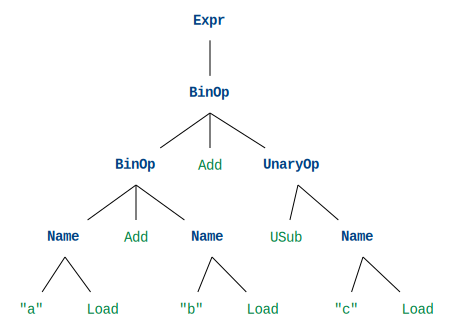

In [12]:
%%showast
((a + b) + (- c))
